<a href="https://colab.research.google.com/github/Simsonsg/ARI3212-Advanced-Reinforcement-Learning/blob/main/Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apply Standard DQN and Double DQN to LunarLander-v3

In [13]:
!pip -q install gymnasium[box2d]
!pip -q install renderlab
!apt-get install swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [14]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995  # per-episode decay
TARGET_UPDATE_FREQ = 10  # update target network every N episodes
MAX_EPISODES = 2000
SOLVE_SCORE = 195.0

In [16]:
env = gym.make("LunarLander-v3", render_mode="rgb_array") #init environment with default params
obs, info = env.reset()
episode_reward = 0.0

In [17]:
experience = namedtuple('Transition', ['states', 'actions', 'rewards', 'dones', 'next_states'])

class replay_mem():
  def __init__(self, env, fullsize, minsize, batchsize):
    self.env = env
    self.memory = deque(maxlen=fullsize)
    self.rewards = deque(maxlen=50)
    self.batchsize = batchsize
    self.minsize = minsize

  def append(self, transition):
    self.memory.append(transition)

  def sample_batch(self):
      batch = random.sample(self.memory, self.batchsize)
      batch = experience(*zip(*batch))

      states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
      actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1).to(device)
      rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1).to(device)
      dones = torch.from_numpy(np.array(batch.dones, dtype=np.float32)).unsqueeze(1).to(device)  # 1.0 if done else 0.0
      next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)).to(device)
      return states, actions, rewards, dones, next_states

  def initialize(self):
      obs, info = self.env.reset()
      for _ in range(self.minsize):
          action = self.env.action_space.sample()
          new_obs, reward, terminated, truncated, info = self.env.step(action)
          done = terminated or truncated
          self.append(experience(obs, action, reward, done, new_obs))
          obs = new_obs
          if done:
              obs, info = self.env.reset()
      return self

In [18]:
replay_memory = replay_mem(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [19]:
states, actions, rewards, dones, next_states = replay_memory.sample_batch()

In [20]:
states  # Transitions ('states', 'actions', 'rewards', 'dones', 'next_states') grouped to separate states, actions, rewards, dones, next_states

tensor([[ 0.0350,  1.3479,  0.4381,  ..., -0.0206,  0.0000,  0.0000],
        [-0.3941,  0.2291,  0.1402,  ..., -0.2512,  0.0000,  0.0000],
        [ 0.5168,  0.6349,  1.0036,  ...,  0.0880,  0.0000,  0.0000],
        ...,
        [ 0.3626,  0.2468,  0.9261,  ..., -0.4171,  0.0000,  0.0000],
        [ 0.0847,  1.5925,  0.2955,  ..., -0.0985,  0.0000,  0.0000],
        [-0.0109,  1.1278, -0.0341,  ...,  0.0423,  0.0000,  0.0000]],
       device='cuda:0')

In [21]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, noutputs),
        )

    def forward(self, x):
        return self.net(x)

In [22]:
def epsilon_greedy_action(policy_net, env, obs, epsilon: float):
    if random.random() <= epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        return int(torch.argmax(policy_net(obs_t), dim=1).item())

learning_rate = 0.001

In [23]:
def train_run(algo: str):
    assert algo in ('dqn', 'double_dqn')


    env = gym.make('LunarLander-v3', render_mode="rgb_array")
    obs, info = env.reset()

    mem = replay_mem(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

    policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
    loss_fn = nn.SmoothL1Loss()

    eps = EPS_START
    episode = 1
    episode_reward = 0.0

    # logs
    stats = {
        'algo': algo,
        'episode_returns': [],
        'avg50': [],
        'losses': [],
        'epsilons': []
    }

    obs, info = env.reset()

    for step in itertools.count():
        action = epsilon_greedy_action(policy_net, env, obs, eps)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        mem.append(experience(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        # optimize
        b_states, b_actions, b_rewards, b_dones, b_next_states = mem.sample_batch()
        q_sa = policy_net(b_states).gather(1, b_actions)

        with torch.no_grad():

            if algo == 'dqn':
                # Standard DQN target: max_a' Q_target(s', a')
                max_next_q = target_net(b_next_states).max(dim=1, keepdim=True).values
                target_q = b_rewards + GAMMA * (1.0 - b_dones) * max_next_q
            else:
                # Double DQN target: a* = argmax_a Q_policy(s',a); use target_net to evaluate a*
                next_actions = policy_net(b_next_states).argmax(dim=1, keepdim=True)
                next_q = target_net(b_next_states).gather(1, next_actions)
                target_q = b_rewards + GAMMA * (1.0 - b_dones) * next_q

        loss = loss_fn(q_sa, target_q)
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
          param.grad.data.clamp_(-1, 1)
        optimizer.step()

        stats['losses'].append(float(loss.item()))

        if done:
            mem.rewards.append(episode_reward)
            avg_res = float(np.mean(mem.rewards))

            stats['episode_returns'].append(float(episode_reward))
            stats['avg50'].append(avg_res)
            stats['epsilons'].append(float(eps))

            if episode % 25 == 0:
                print(f"[{algo}] Episode: {episode:4d} | Avg(50): {avg_res:7.2f} | Eps: {eps:6.3f} | Loss: {loss.item():.4f}")

            if (len(mem.rewards) == mem.rewards.maxlen) and (avg_res >= SOLVE_SCORE):
                print(f"[{algo}] Solved at episode: {episode} | Avg(50): {avg_res:.2f}")
                break

            episode += 1
            if episode > MAX_EPISODES:
                print(f"[{algo}] Stopped at MAX_EPISODES={MAX_EPISODES} | Avg(50): {avg_res:.2f}")
                break

            eps = max(eps * EPS_DECAY, EPS_END)
            obs, info = env.reset()
            episode_reward = 0.0

            if episode % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())

    env.close()
    return policy_net, stats

In [24]:
dqn_policy_std, stats_dqn = train_run('dqn')
ddqn_policy, stats_ddqn = train_run('double_dqn')

[dqn] Episode:   25 | Avg(50): -156.32 | Eps:  0.887 | Loss: 1.5757
[dqn] Episode:   50 | Avg(50): -144.72 | Eps:  0.782 | Loss: 1.0565
[dqn] Episode:   75 | Avg(50): -120.01 | Eps:  0.690 | Loss: 0.9330
[dqn] Episode:  100 | Avg(50):  -86.99 | Eps:  0.609 | Loss: 0.4149
[dqn] Episode:  125 | Avg(50):  -56.84 | Eps:  0.537 | Loss: 1.5440
[dqn] Episode:  150 | Avg(50):  -52.00 | Eps:  0.474 | Loss: 0.8537
[dqn] Episode:  175 | Avg(50):  -43.16 | Eps:  0.418 | Loss: 0.9510
[dqn] Episode:  200 | Avg(50):  -12.60 | Eps:  0.369 | Loss: 0.7449
[dqn] Episode:  225 | Avg(50):    2.07 | Eps:  0.325 | Loss: 0.4520
[dqn] Episode:  250 | Avg(50):    4.17 | Eps:  0.287 | Loss: 0.6747
[dqn] Episode:  275 | Avg(50):   -1.77 | Eps:  0.253 | Loss: 0.8716
[dqn] Episode:  300 | Avg(50):   32.51 | Eps:  0.223 | Loss: 0.2097
[dqn] Episode:  325 | Avg(50):   72.97 | Eps:  0.197 | Loss: 0.3759
[dqn] Episode:  350 | Avg(50):   75.56 | Eps:  0.174 | Loss: 0.5946
[dqn] Episode:  375 | Avg(50):   95.32 | Eps:  0

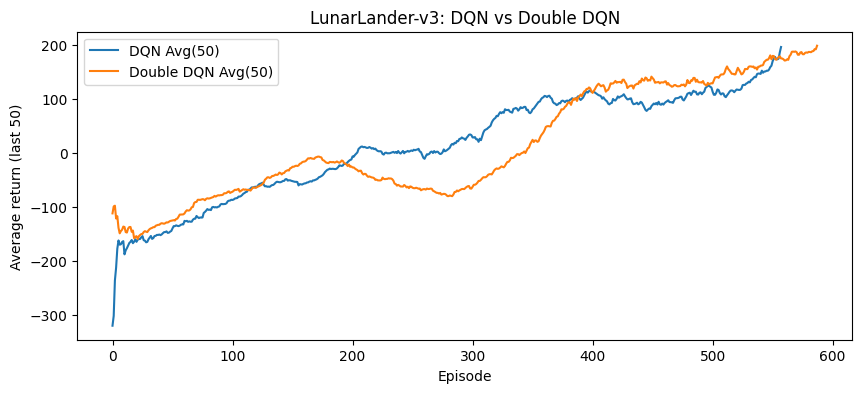

In [25]:
plt.figure(figsize=(10,4))
plt.plot(stats_dqn['avg50'], label='DQN Avg(50)')
plt.plot(stats_ddqn['avg50'], label='Double DQN Avg(50)')
plt.title('LunarLander-v3: DQN vs Double DQN')
plt.xlabel('Episode')
plt.ylabel('Average return (last 50)')
plt.legend()
plt.show()

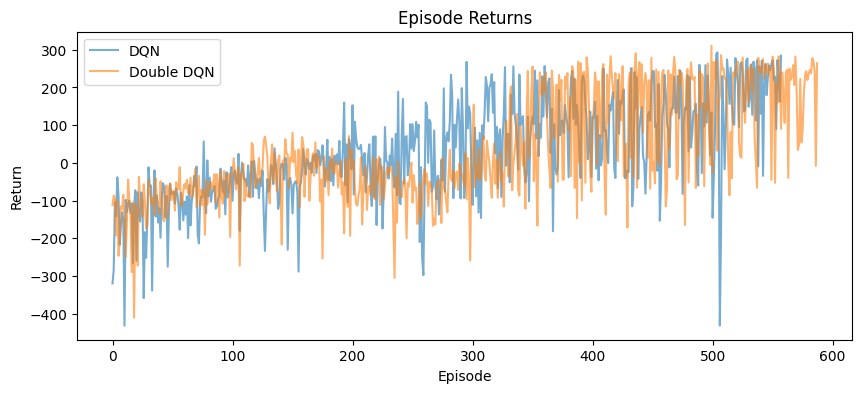

In [26]:
plt.figure(figsize=(10,4))
plt.plot(stats_dqn['episode_returns'], alpha=0.6, label='DQN')
plt.plot(stats_ddqn['episode_returns'], alpha=0.6, label='Double DQN')
plt.title('Episode Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()
plt.show()

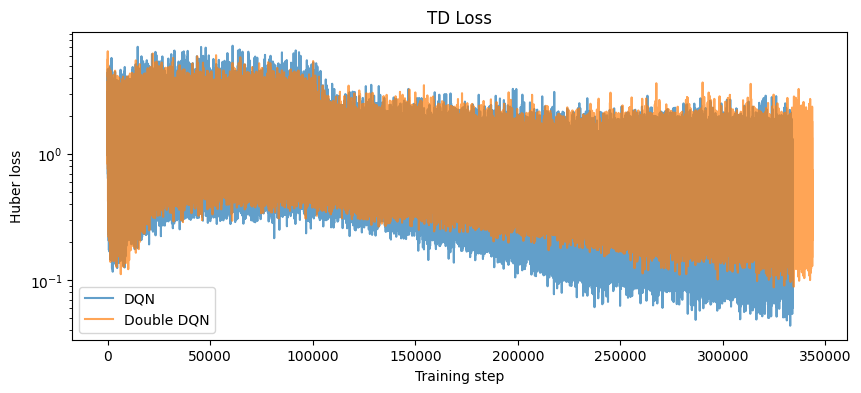

In [27]:
plt.figure(figsize=(10,4))
plt.plot(stats_dqn['losses'], alpha=0.7, label='DQN')
plt.plot(stats_ddqn['losses'], alpha=0.7, label='Double DQN')
plt.title('TD Loss')
plt.xlabel('Training step')
plt.ylabel('Huber loss')
plt.legend()
plt.yscale('log')  # optional but useful
plt.show()

In [28]:
import renderlab as rl

def record_video(policy_net, out_dir: str):
    video_env = gym.make("LunarLander-v3", render_mode="rgb_array", gravity=-10.0,
               enable_wind=True, wind_power=25.0, turbulence_power=2)
    video_env = rl.RenderFrame(video_env, out_dir)

    obs, info = video_env.reset()
    while True:
        with torch.no_grad():
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            action = int(torch.argmax(policy_net(obs_t), dim=1).item())
        obs, reward, terminated, truncated, info = video_env.step(action)
        if terminated or truncated:
            break
    video_env.play()

record_video(dqn_policy_std, './video_dqn')
record_video(ddqn_policy, './video_ddqn')

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
